# German Credit Risk Prediction - Complete ML Analysis

## Project Overview
This notebook implements an end-to-end machine learning pipeline to predict credit default risk for banking institutions, achieving 92.39% AUC with XGBoost.

**Business Objective:** Develop an automated system to assess credit risk and minimize loan defaults through predictive modeling.

**Dataset:** German Credit Data - 1000 customers with 10 financial and demographic features

**Key Results:**
- **Best Model:** XGBoost with 92.39% ROC-AUC
- **Feature Engineering:** 10 → 29 features after encoding
- **Explainability:** SHAP analysis for model interpretability
- **Missing Data:** Smart handling of 39.4% missing values

---

## Analysis Pipeline

### 1. Environment Setup
- Automatic dependency installation and validation
- Library imports and configuration
- Directory creation for outputs

### 2. Data Loading & Initial Inspection
- Dataset loading from root directory
- Initial data exploration and structure analysis
- Basic statistics and data quality assessment

### 3. Detailed Data Analysis
- Missing value analysis and patterns
- Data types and distributions
- Target variable distribution analysis

### 4. Exploratory Data Analysis (EDA)
- Univariate analysis with enhanced visualizations
- Bivariate analysis by risk categories
- Categorical variables analysis with risk rates

### 5. Correlation & Relationship Analysis
- Correlation matrix for numerical variables
- Feature relationship identification
- Strong and moderate correlation detection

### 6. Data Preprocessing
- Feature and target separation
- Missing value imputation strategies
- Categorical encoding (one-hot encoding)

### 7. Feature Engineering
- Creation of derived features (age_groups, amount_groups, duration_groups)
- Amount per month calculation
- Feature scaling and normalization

### 8. Model Development
- **Baseline Models:** Logistic Regression, Random Forest, XGBoost
- **Hyperparameter Optimization:** GridSearchCV with 5-fold CV
- **Performance Evaluation:** ROC-AUC, accuracy, precision, recall
- **Model Comparison:** ROC curves analysis

### 9. Model Interpretability
- **SHAP Analysis:** TreeExplainer for feature importance
- **Business Insights:** Risk factor identification
- **Visualization:** Feature impact plots

### 10. Model Finalization & Saving
- Best model selection and validation
- Model serialization to `../models/` directory
- Performance documentation and reporting

### 11. Practical Model Demonstration
- **Interactive Prediction Function:** Complete preprocessing pipeline
- **Real Client Examples:** Favorable, risky, and intermediate profiles
- **Live Testing:** Customizable client parameter testing
- **Business Applications:** Decision support and risk assessment

---

**Expected Runtime:** ~5-10 minutes (depending on hardware)
**Output:** Trained models and demonstration examples with live predictions

## Setup & Dependencies Installation

Before running this analysis, make sure to install all required dependencies. This notebook will automatically install them if needed.

In [25]:
# Install required dependencies from requirements.txt
# Uncomment and run this cell if you need to install dependencies

import subprocess
import sys
import os

def install_requirements():
    """Install packages from requirements.txt"""
    # Check if requirements.txt exists
    req_file = "../requirements.txt"
    if os.path.exists(req_file):
        try:
            print("Installing dependencies from requirements.txt...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", req_file])
            print("All dependencies installed successfully!")
        except subprocess.CalledProcessError as e:
            print(f"Error installing dependencies: {e}")
            print("You may need to install manually: pip install -r requirements.txt")
    else:
        print("requirements.txt not found. Installing core packages...")
        core_packages = ["pandas>=2.3.0", "scikit-learn>=1.7.0", "xgboost>=3.0.0", 
                        "shap>=0.48.0", "matplotlib", "seaborn", "numpy"]
        for package in core_packages:
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            except subprocess.CalledProcessError:
                print(f"Failed to install {package}")

# Uncomment the next line to run installation
# install_requirements()

In [26]:
# Verify all dependencies are installed and working
print("Checking dependencies...")

# List of required packages
required_packages = {
    'pandas': 'Data manipulation and analysis',
    'numpy': 'Numerical computing',
    'scikit-learn': 'Machine learning library (sklearn)',
    'xgboost': 'Gradient boosting framework',
    'matplotlib': 'Plotting library',
    'seaborn': 'Statistical data visualization',
    'shap': 'Model explainability',
    'joblib': 'Model serialization'
}

# Check each package
missing_packages = []
for package, description in required_packages.items():
    try:
        if package == 'scikit-learn':
            import sklearn
            version = sklearn.__version__
        else:
            module = __import__(package)
            version = getattr(module, '__version__', 'unknown')
        print(f"✓ {package:15} v{version:10} - {description}")
    except ImportError:
        print(f"✗ {package:15} {'':10} - {description} (NOT INSTALLED)")
        missing_packages.append(package)

if missing_packages:
    print(f"\nMissing packages: {', '.join(missing_packages)}")
    print("Run the installation cell above or: pip install -r requirements.txt")
else:
    print("\nAll dependencies are installed and ready!")
    print("You can now run the analysis safely.")

Checking dependencies...
✓ pandas          v2.3.1      - Data manipulation and analysis
✓ numpy           v2.2.6      - Numerical computing
✓ scikit-learn    v1.7.1      - Machine learning library (sklearn)
✓ xgboost         v3.0.4      - Gradient boosting framework
✓ matplotlib      v3.10.5     - Plotting library
✓ seaborn         v0.13.2     - Statistical data visualization
✓ shap            v0.48.0     - Model explainability
✓ joblib          v1.5.1      - Model serialization

All dependencies are installed and ready!
You can now run the analysis safely.


---

## Analysis Start

Now that all dependencies are verified, let's begin the credit risk analysis!

In [27]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import xgboost as xgb

# Model interpretation
import shap

# File management
import joblib
import json
import os

# Create directories for outputs
os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)
os.makedirs('../results/figures', exist_ok=True)
os.makedirs('../results/reports', exist_ok=True)

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print("Scikit-learn available")
print("XGBoost available") 
print("SHAP available")

All libraries imported successfully!
Pandas version: 2.3.1
Scikit-learn available
XGBoost available
SHAP available


In [28]:
# Load the German Credit dataset
data_path = "../german_credit_data_complete.csv"
df = pd.read_csv(data_path)

print("GERMAN CREDIT DATASET LOADING")
print("=" * 50)
print("Dataset loaded successfully!")
print(f"Dimensions: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nDATASET PREVIEW")
print("=" * 30)
print(df.head())

print("\nBASIC STATISTICS")
print("=" * 20)
print(df.describe())

GERMAN CREDIT DATASET LOADING
Dataset loaded successfully!
Dimensions: 1000 rows, 10 columns
Memory usage: 0.33 MB

DATASET PREVIEW
   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment   bad  
4        24                  car   bad  

BASIC STATISTICS
               Age          Job  Credit amount     Duration
count  1000.000000  1000.000000    1000.000000  1000.000000
mean     

In [29]:
# Detailed dataset information
print("\nDETAILED DATASET INFORMATION")
print("=" * 30)
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print("\nDATA TYPES")
print("=" * 20)
print(df.dtypes)

print("\nMISSING VALUES")
print("=" * 25)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
missing_summary = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
if len(missing_summary) > 0:
    print(missing_summary)
else:
    print("No missing values detected!")

print("\nTARGET VARIABLE DISTRIBUTION")
print("=" * 40)
target_dist = df['Risk'].value_counts()
print(target_dist)
print(f"\nPercentage of 'bad': {(df['Risk'] == 'bad').mean()*100:.1f}%")
print(f"Percentage of 'good': {(df['Risk'] == 'good').mean()*100:.1f}%")

print("\nCATEGORICAL VARIABLES UNIQUE VALUES")
print("=" * 40)
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\n{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Categories: {list(df[col].value_counts().index)}")

print("\nNUMERICAL VARIABLES SUMMARY")
print("=" * 30)
numerical_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'Unnamed: 0']
for col in numerical_columns:
    print(f"\n{col}:")
    print(f"  Min: {df[col].min()}")
    print(f"  Max: {df[col].max()}")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Std: {df[col].std():.2f}")

print("\nDATASET QUALITY CHECK")
print("=" * 25)
print(f"Total records: {len(df)}")
print(f"Complete records (no missing): {df.dropna().shape[0]}")
print(f"Records with missing data: {df.shape[0] - df.dropna().shape[0]}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Check for potential data quality issues
print(f"\nPOTENTIAL DATA ISSUES:")
print(f"- Age range: {df['Age'].min()} to {df['Age'].max()} years")
print(f"- Negative amounts: {(df['Credit amount'] < 0).sum()}")
print(f"- Zero duration: {(df['Duration'] == 0).sum()}")
print(f"- Job codes range: {df['Job'].min()} to {df['Job'].max()}")


DETAILED DATASET INFORMATION
Shape: (1000, 10)
Columns: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']

DATA TYPES
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

MISSING VALUES
                  Missing Count  Missing Percentage
Checking account            394                39.4
Saving accounts             183                18.3

TARGET VARIABLE DISTRIBUTION
Risk
good    603
bad     397
Name: count, dtype: int64

Percentage of 'bad': 39.7%
Percentage of 'good': 60.3%

CATEGORICAL VARIABLES UNIQUE VALUES

Sex:
  Unique values: 2
  Categories: ['male', 'female']

Housing:
  Unique values: 3
  Categories: ['own', 'rent', 'free']

Saving accounts:
  Unique values: 4
  Categories: [

CREATING EXPLORATORY VISUALIZATIONS


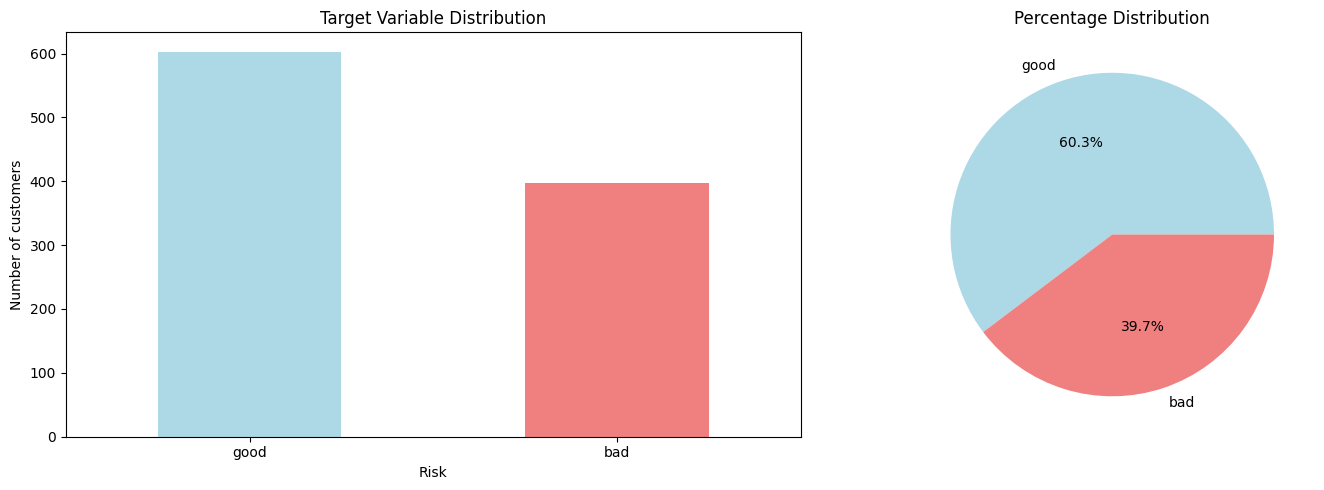


DESCRIPTIVE STATISTICS
               Age          Job  Credit amount     Duration
count  1000.000000  1000.000000    1000.000000  1000.000000
mean     35.546000     1.904000    3271.258000    20.903000
std      11.375469     0.653614    2822.736876    12.058814
min      19.000000     0.000000     250.000000     4.000000
25%      27.000000     2.000000    1365.500000    12.000000
50%      33.000000     2.000000    2319.500000    18.000000
75%      42.000000     2.000000    3972.250000    24.000000
max      75.000000     3.000000   18424.000000    72.000000


In [30]:
# Exploratory visualizations
print("CREATING EXPLORATORY VISUALIZATIONS")

# Target variable distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
target_counts = df['Risk'].value_counts()
colors = ['lightblue', 'lightcoral']
target_counts.plot(kind='bar', ax=ax1, color=colors)
ax1.set_title('Target Variable Distribution')
ax1.set_xlabel('Risk')
ax1.set_ylabel('Number of customers')
ax1.tick_params(axis='x', rotation=0)

# Pie chart
ax2.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', colors=colors)
ax2.set_title('Percentage Distribution')

plt.tight_layout()
plt.show()

# Select numerical columns
numerical_data = df.select_dtypes(include=[np.number])
print("\nDESCRIPTIVE STATISTICS")
print("=" * 35)
print(numerical_data.describe())


NUMERICAL VARIABLES DISTRIBUTION
Numerical variables: ['Age', 'Job', 'Credit amount', 'Duration']


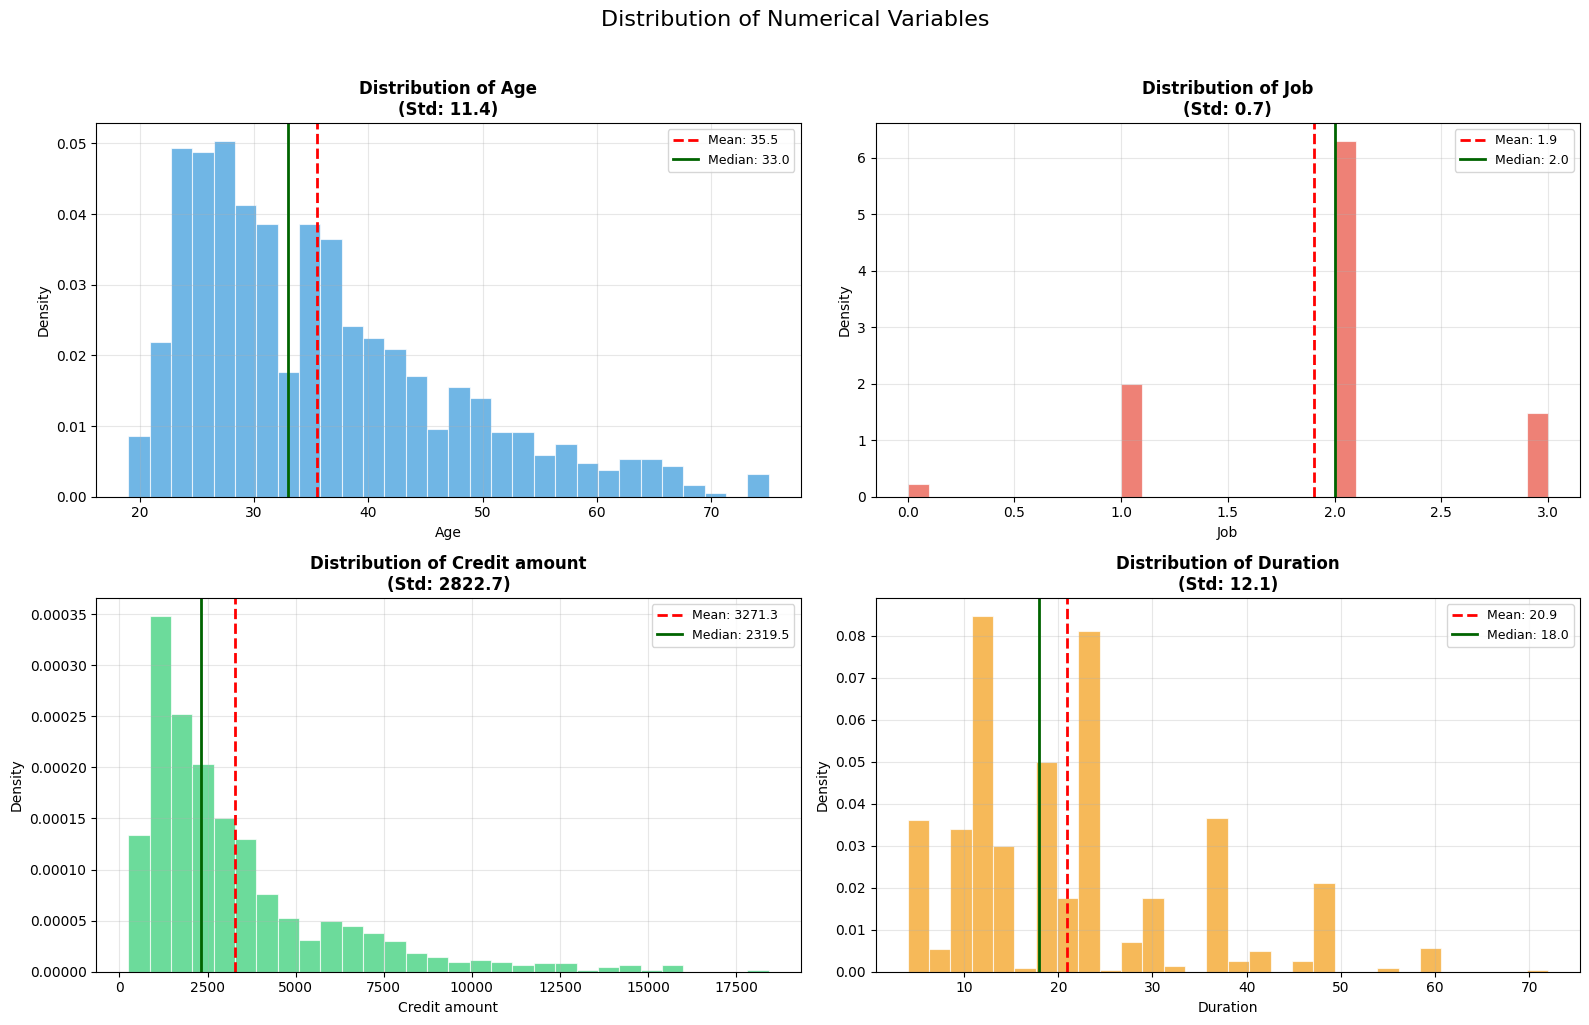


COMPARISON BY RISK LEVEL


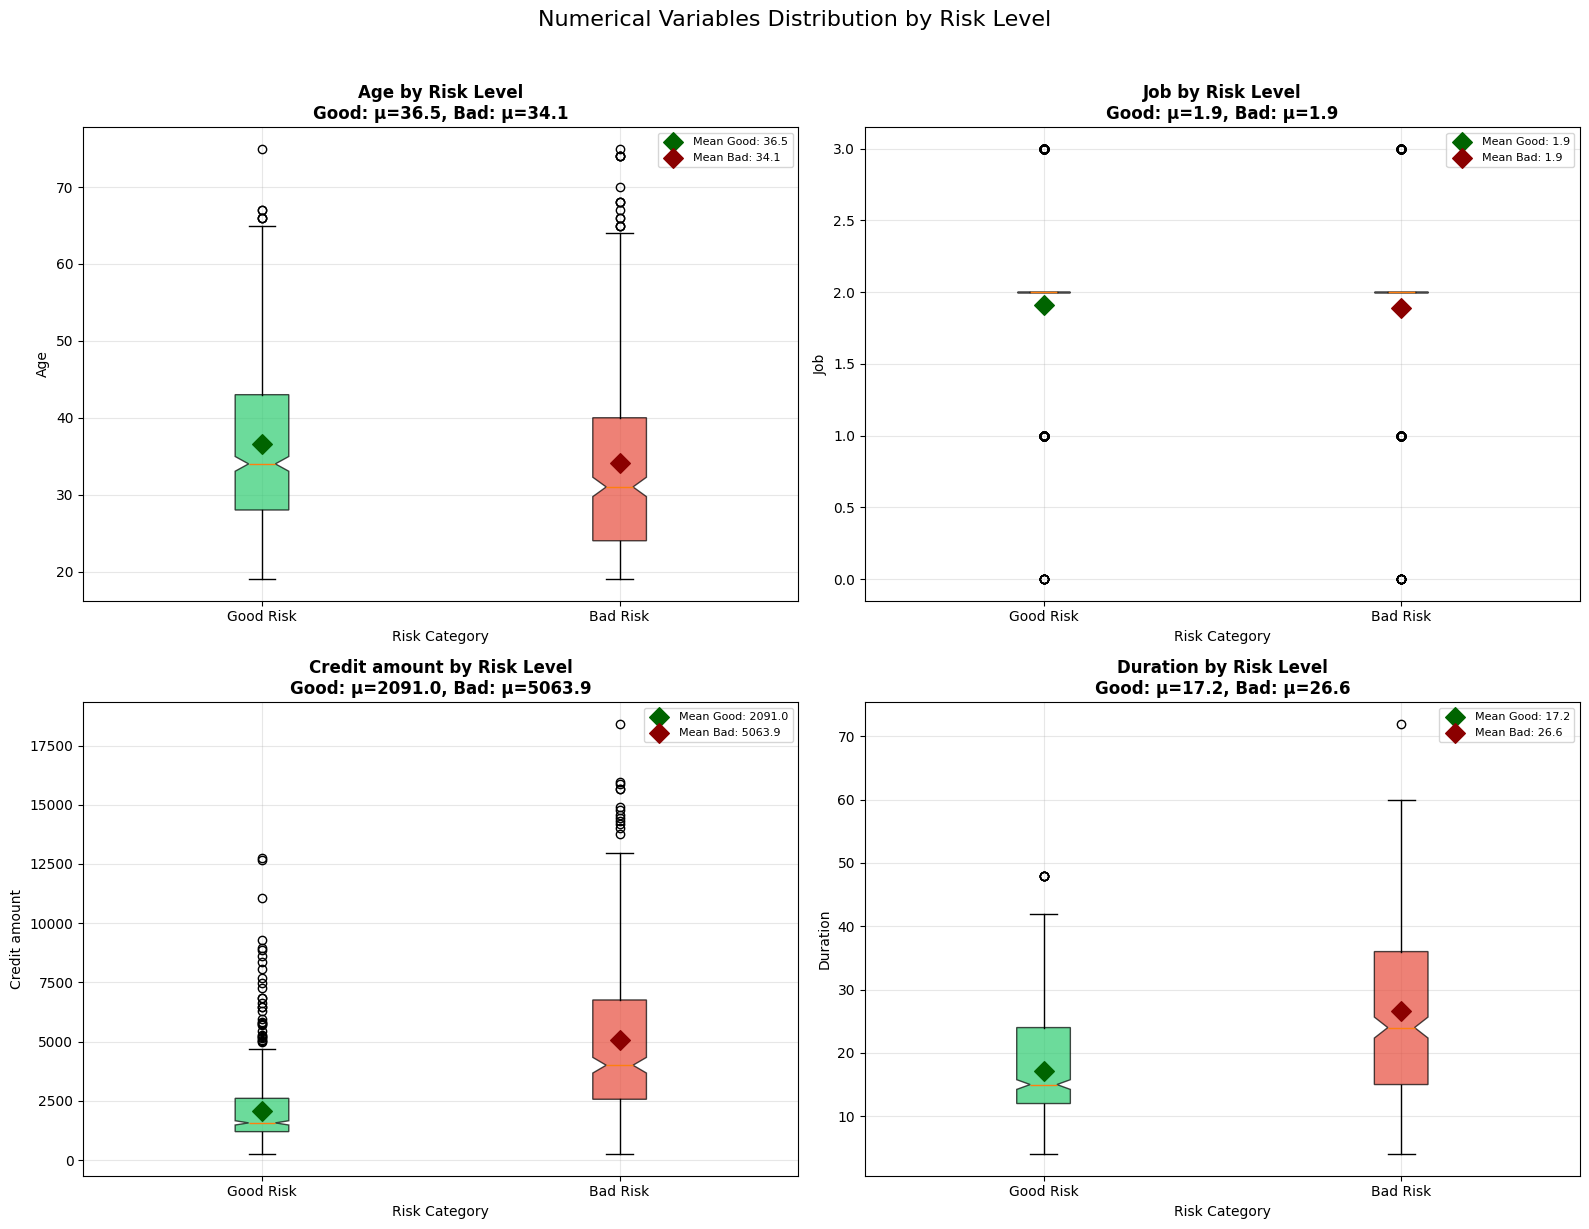


STATISTICAL COMPARISON BY RISK

AGE:
  Good Risk - Mean: 36.52, Median: 34.00, Std: 10.77
  Bad Risk  - Mean: 34.07, Median: 31.00, Std: 12.10
  Difference: 2.46

JOB:
  Good Risk - Mean: 1.91, Median: 2.00, Std: 0.61
  Bad Risk  - Mean: 1.89, Median: 2.00, Std: 0.71
  Difference: 0.02

CREDIT AMOUNT:
  Good Risk - Mean: 2091.03, Median: 1572.00, Std: 1557.77
  Bad Risk  - Mean: 5063.90, Median: 4006.00, Std: 3327.00
  Difference: 2972.88

DURATION:
  Good Risk - Mean: 17.17, Median: 15.00, Std: 8.38
  Bad Risk  - Mean: 26.58, Median: 24.00, Std: 14.37
  Difference: 9.41


In [31]:
# Numerical variables distribution analysis
# Filter out index column and select only proper numerical variables
numerical_cols = [col for col in df.select_dtypes(include=[np.number]).columns.tolist() 
                  if col not in ['Unnamed: 0']]
print(f"\nNUMERICAL VARIABLES DISTRIBUTION")
print(f"Numerical variables: {numerical_cols}")

# Create histograms for numerical variables with improved styling
n_cols = len(numerical_cols)
n_rows = (n_cols + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5*n_rows))
fig.suptitle('Distribution of Numerical Variables', fontsize=16, y=1.02)

# Handle different subplot configurations
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']  # Better color palette

for i, col in enumerate(numerical_cols):
    # Calculate statistics
    mean_val = df[col].mean()
    median_val = df[col].median()
    std_val = df[col].std()
    
    # Create histogram with improved styling
    axes[i].hist(df[col], bins=30, alpha=0.7, color=colors[i % len(colors)], 
                edgecolor='white', linewidth=0.8, density=True)
    
    # Add mean and median lines
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_val:.1f}')
    axes[i].axvline(median_val, color='darkgreen', linestyle='-', linewidth=2, 
                   label=f'Median: {median_val:.1f}')
    
    # Improve title and labels
    axes[i].set_title(f'Distribution of {col}\n(Std: {std_val:.1f})', 
                     fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Enhanced Box plots by Risk with better visualization
print("\nCOMPARISON BY RISK LEVEL")
n_cols_box = len(numerical_cols)
n_rows_box = (n_cols_box + 1) // 2
fig, axes = plt.subplots(n_rows_box, 2, figsize=(16, 6*n_rows_box))
fig.suptitle('Numerical Variables Distribution by Risk Level', fontsize=16, y=1.02)

# Handle different subplot configurations
if n_rows_box == 1:
    axes = [axes] if n_cols_box == 1 else axes
else:
    axes = axes.flatten()

# Define colors for risk categories
risk_colors = {'good': '#2ecc71', 'bad': '#e74c3c'}

for i, col in enumerate(numerical_cols):
    # Create side-by-side box plots
    good_data = df[df['Risk'] == 'good'][col]
    bad_data = df[df['Risk'] == 'bad'][col]
    
    box_data = [good_data, bad_data]
    box_plot = axes[i].boxplot(box_data, labels=['Good Risk', 'Bad Risk'], 
                              patch_artist=True, notch=True)
    
    # Color the boxes
    box_plot['boxes'][0].set_facecolor(risk_colors['good'])
    box_plot['boxes'][1].set_facecolor(risk_colors['bad'])
    
    # Add transparency
    for box in box_plot['boxes']:
        box.set_alpha(0.7)
    
    # Calculate and display statistics
    good_mean = good_data.mean()
    bad_mean = bad_data.mean()
    
    axes[i].set_title(f'{col} by Risk Level\nGood: μ={good_mean:.1f}, Bad: μ={bad_mean:.1f}', 
                     fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Risk Category', fontsize=10)
    axes[i].set_ylabel(col, fontsize=10)
    axes[i].grid(True, alpha=0.3)
    
    # Add mean markers
    axes[i].scatter([1], [good_mean], color='darkgreen', s=100, marker='D', 
                   label=f'Mean Good: {good_mean:.1f}', zorder=5)
    axes[i].scatter([2], [bad_mean], color='darkred', s=100, marker='D', 
                   label=f'Mean Bad: {bad_mean:.1f}', zorder=5)
    axes[i].legend(fontsize=8)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Additional statistical comparison
print("\nSTATISTICAL COMPARISON BY RISK")
print("=" * 40)
for col in numerical_cols:
    good_data = df[df['Risk'] == 'good'][col]
    bad_data = df[df['Risk'] == 'bad'][col]
    
    print(f"\n{col.upper()}:")
    print(f"  Good Risk - Mean: {good_data.mean():.2f}, Median: {good_data.median():.2f}, Std: {good_data.std():.2f}")
    print(f"  Bad Risk  - Mean: {bad_data.mean():.2f}, Median: {bad_data.median():.2f}, Std: {bad_data.std():.2f}")
    print(f"  Difference: {abs(good_data.mean() - bad_data.mean()):.2f}")


CATEGORICAL VARIABLES ANALYSIS
Categorical variables: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

SEX
------------------------------
Sex
male      690
female    310
Name: count, dtype: int64

Percentages:
  male: 69.0%
  female: 31.0%

HOUSING
------------------------------
Housing
own     713
rent    179
free    108
Name: count, dtype: int64

Percentages:
  own: 71.3%
  rent: 17.9%
  free: 10.8%

SAVING ACCOUNTS
------------------------------
Saving accounts
little        603
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64

Percentages:
  little: 60.3%
  moderate: 10.3%
  quite rich: 6.3%
  rich: 4.8%

CHECKING ACCOUNT
------------------------------
Checking account
little      274
moderate    269
rich         63
Name: count, dtype: int64

Percentages:
  little: 27.4%
  moderate: 26.9%
  rich: 6.3%

PURPOSE
------------------------------
Purpose
car                    337
radio/TV               280
furniture/equipment 

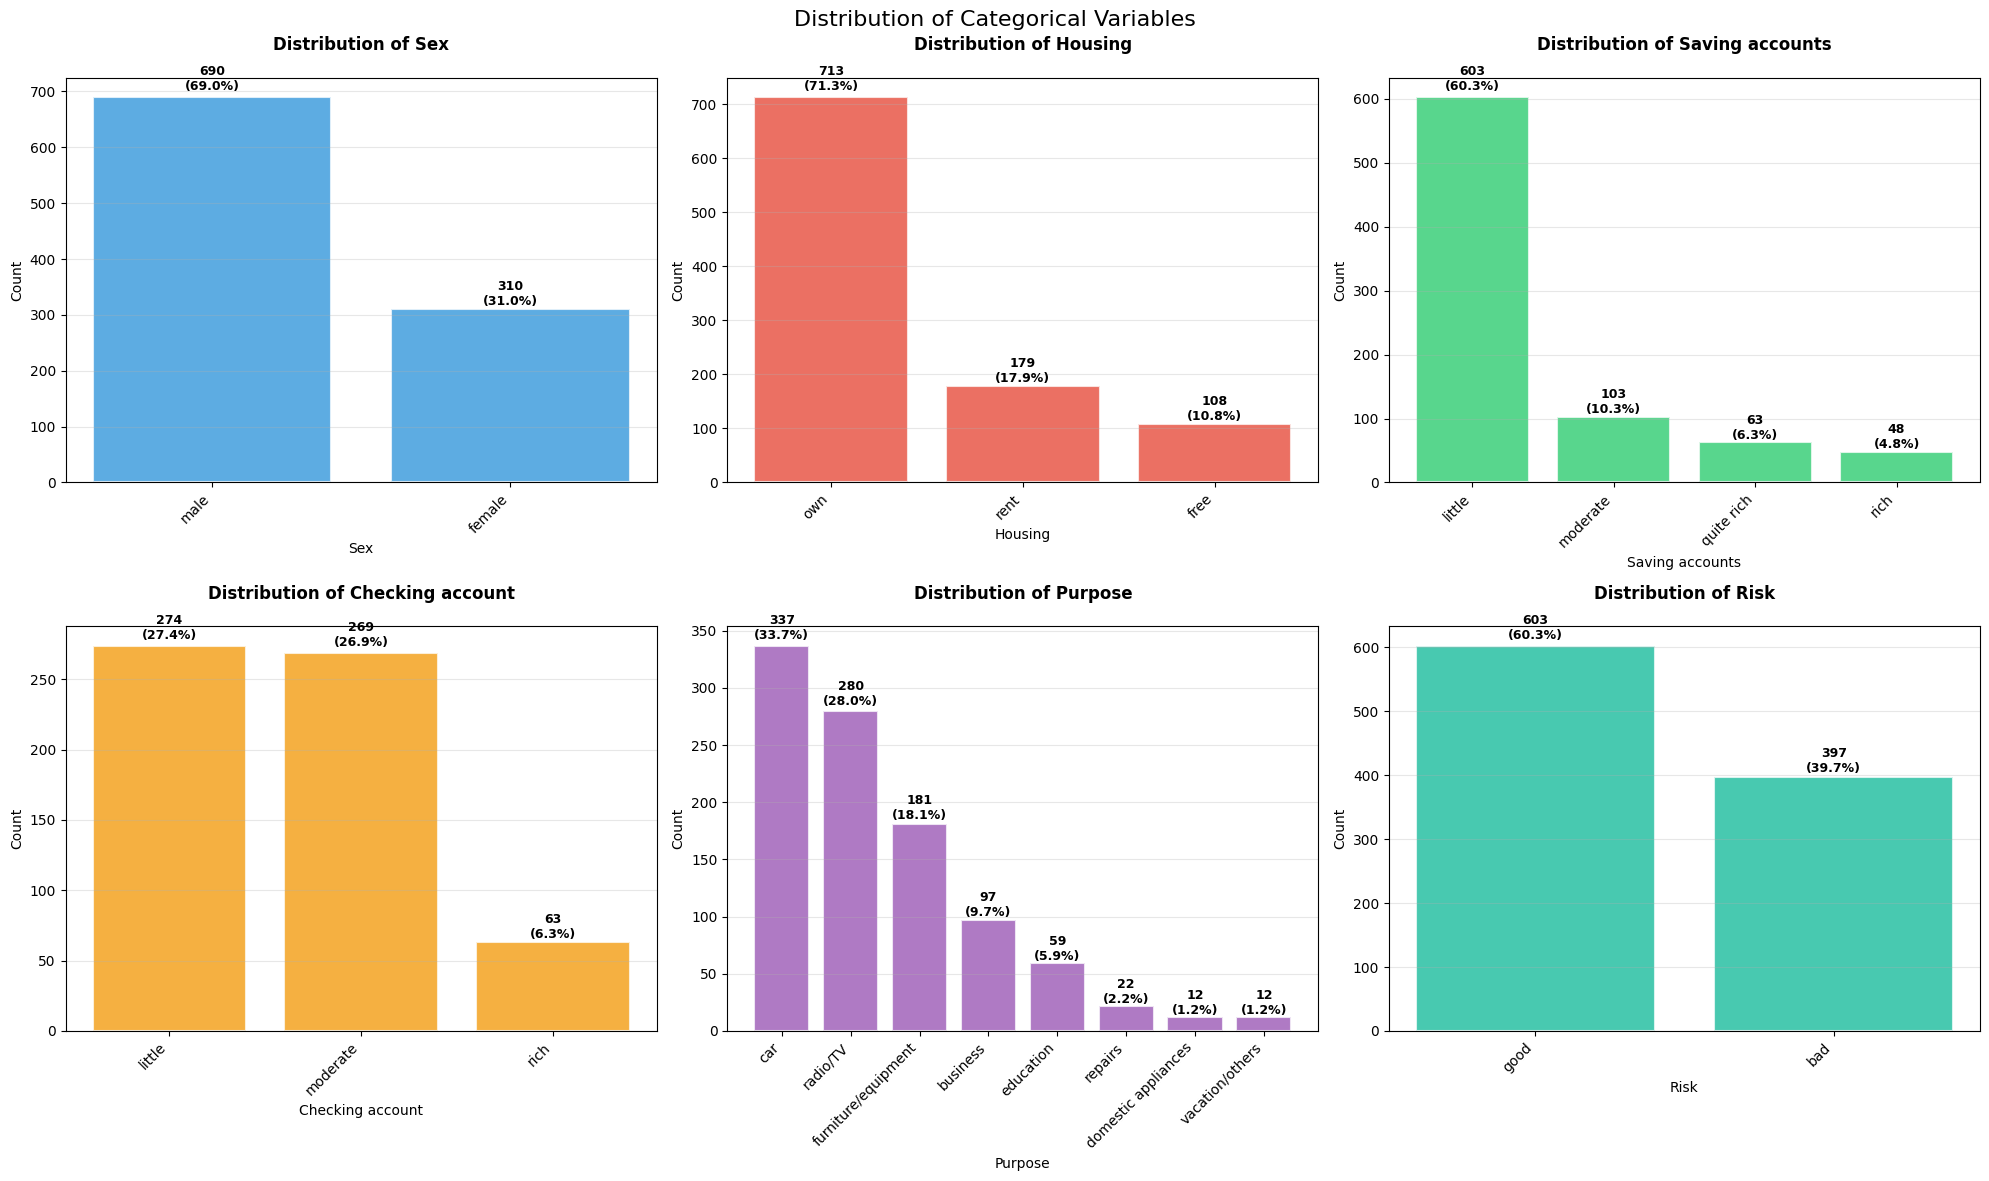


RISK ANALYSIS BY CATEGORICAL VARIABLES


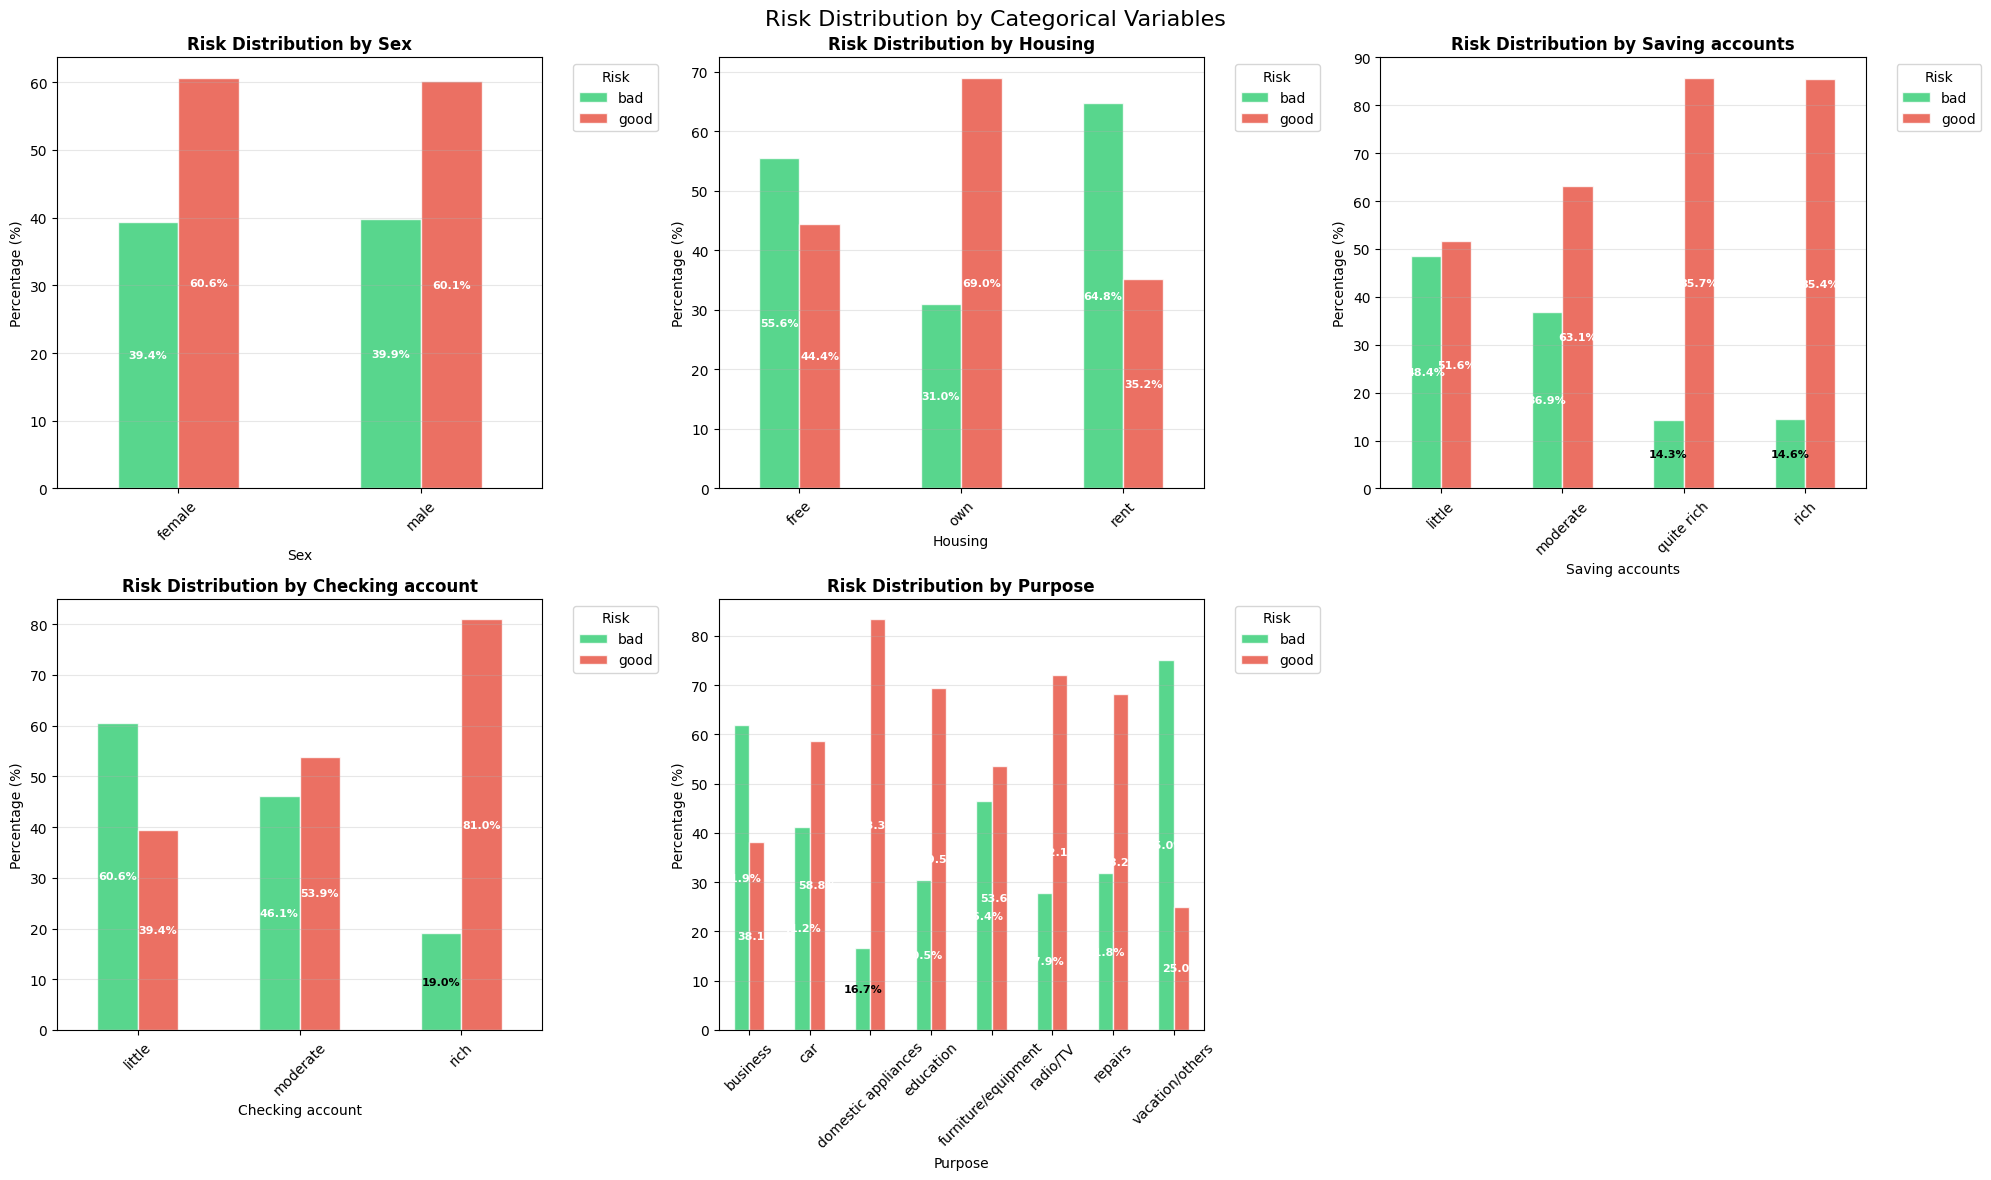


RISK RATE BY CATEGORICAL VARIABLES

SEX:
  male: 39.9% bad risk
  female: 39.4% bad risk
  → Highest risk: male (39.9%)
  → Lowest risk: female (39.4%)

HOUSING:
  rent: 64.8% bad risk
  free: 55.6% bad risk
  own: 31.0% bad risk
  → Highest risk: rent (64.8%)
  → Lowest risk: own (31.0%)

SAVING ACCOUNTS:
  little: 48.4% bad risk
  moderate: 36.9% bad risk
  rich: 14.6% bad risk
  quite rich: 14.3% bad risk
  → Highest risk: little (48.4%)
  → Lowest risk: quite rich (14.3%)

CHECKING ACCOUNT:
  little: 60.6% bad risk
  moderate: 46.1% bad risk
  rich: 19.0% bad risk
  → Highest risk: little (60.6%)
  → Lowest risk: rich (19.0%)

PURPOSE:
  vacation/others: 75.0% bad risk
  business: 61.9% bad risk
  furniture/equipment: 46.4% bad risk
  car: 41.2% bad risk
  repairs: 31.8% bad risk
  education: 30.5% bad risk
  radio/TV: 27.9% bad risk
  domestic appliances: 16.7% bad risk
  → Highest risk: vacation/others (75.0%)
  → Lowest risk: domestic appliances (16.7%)


In [32]:
# Categorical variables analysis with enhanced visualizations
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nCATEGORICAL VARIABLES ANALYSIS")
print(f"Categorical variables: {categorical_cols}")

# Analyze each categorical variable
for col in categorical_cols:
    print(f"\n{col.upper()}")
    print("-" * 30)
    unique_values = df[col].value_counts()
    print(unique_values)
    
    # Calculate percentage
    percentages = (unique_values / len(df) * 100).round(2)
    print(f"\nPercentages:")
    for value, pct in percentages.items():
        print(f"  {value}: {pct}%")

# Enhanced visualization of categorical variables
n_cats = len(categorical_cols)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution of Categorical Variables', fontsize=16, y=0.98)
axes = axes.flatten()

# Color palette
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for i, col in enumerate(categorical_cols):
    if i < len(axes):
        # Count plot with improved styling
        counts = df[col].value_counts()
        bars = axes[i].bar(range(len(counts)), counts.values, 
                          color=colors[i % len(colors)], alpha=0.8, 
                          edgecolor='white', linewidth=1.5)
        
        # Add value labels on bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                        f'{int(height)}\n({height/len(df)*100:.1f}%)',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold', pad=20)
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel('Count', fontsize=10)
        axes[i].set_xticks(range(len(counts)))
        axes[i].set_xticklabels(counts.index, rotation=45, ha='right')
        axes[i].grid(True, alpha=0.3, axis='y')

# Remove empty subplots
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Risk analysis by categorical variables
print("\nRISK ANALYSIS BY CATEGORICAL VARIABLES")
print("=" * 45)

# Create risk comparison plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Risk Distribution by Categorical Variables', fontsize=16, y=0.98)
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if i < len(axes) and col != 'Risk':  # Skip the target variable itself
        # Create cross-tabulation
        cross_tab = pd.crosstab(df[col], df['Risk'], normalize='index') * 100
        
        # Create stacked bar chart
        cross_tab.plot(kind='bar', ax=axes[i], 
                      color=['#2ecc71', '#e74c3c'], alpha=0.8,
                      edgecolor='white', linewidth=1)
        
        axes[i].set_title(f'Risk Distribution by {col}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel('Percentage (%)', fontsize=10)
        axes[i].legend(title='Risk', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3, axis='y')
        
        # Add percentage labels
        for p in axes[i].patches:
            percentage = f'{p.get_height():.1f}%'
            axes[i].annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()/2),
                           ha='center', va='center', fontsize=8, fontweight='bold',
                           color='white' if p.get_height() > 20 else 'black')

# Remove empty subplots
for j in range(len(categorical_cols)-1, len(axes)):  # -1 because we skip 'Risk'
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Statistical summary of risk by categories
print("\nRISK RATE BY CATEGORICAL VARIABLES")
print("=" * 35)
for col in categorical_cols:
    if col != 'Risk':
        print(f"\n{col.upper()}:")
        risk_by_cat = df.groupby(col)['Risk'].apply(lambda x: (x == 'bad').mean() * 100).sort_values(ascending=False)
        for category, bad_rate in risk_by_cat.items():
            print(f"  {category}: {bad_rate:.1f}% bad risk")
        
        # Find the category with highest/lowest risk
        highest_risk = risk_by_cat.idxmax()
        lowest_risk = risk_by_cat.idxmin()
        print(f"  → Highest risk: {highest_risk} ({risk_by_cat[highest_risk]:.1f}%)")
        print(f"  → Lowest risk: {lowest_risk} ({risk_by_cat[lowest_risk]:.1f}%)")

CORRELATION ANALYSIS


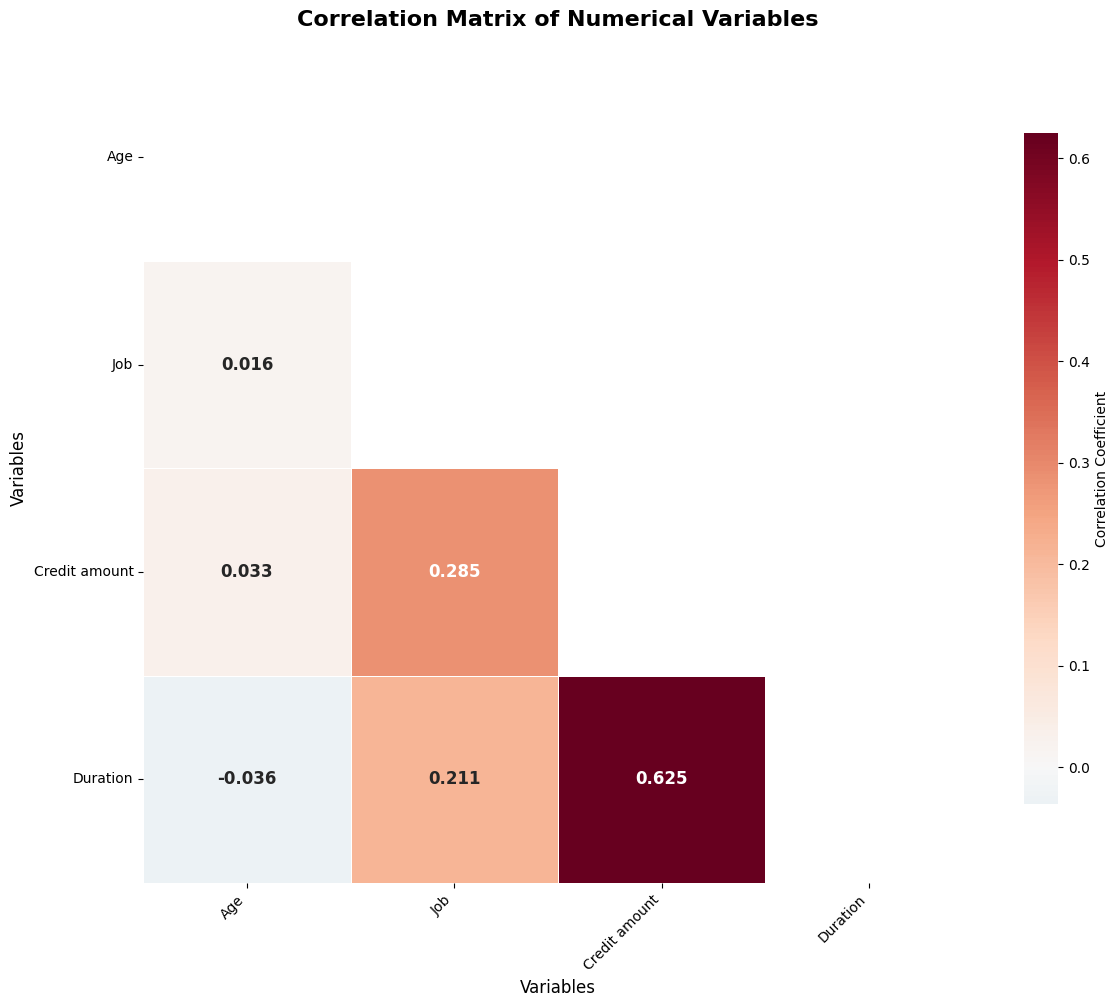


CORRELATION ANALYSIS RESULTS
------------------------------

ALL CORRELATIONS (sorted by strength):
   Variable 1    Variable 2  Correlation  Strength
Credit amount      Duration        0.625     0.625
          Job Credit amount        0.285     0.285
          Job      Duration        0.211     0.211
          Age      Duration       -0.036     0.036
          Age Credit amount        0.033     0.033
          Age           Job        0.016     0.016

STRONG CORRELATIONS (|r| > 0.5):
----------------------------------------
   Variable 1 Variable 2  Correlation
Credit amount   Duration        0.625


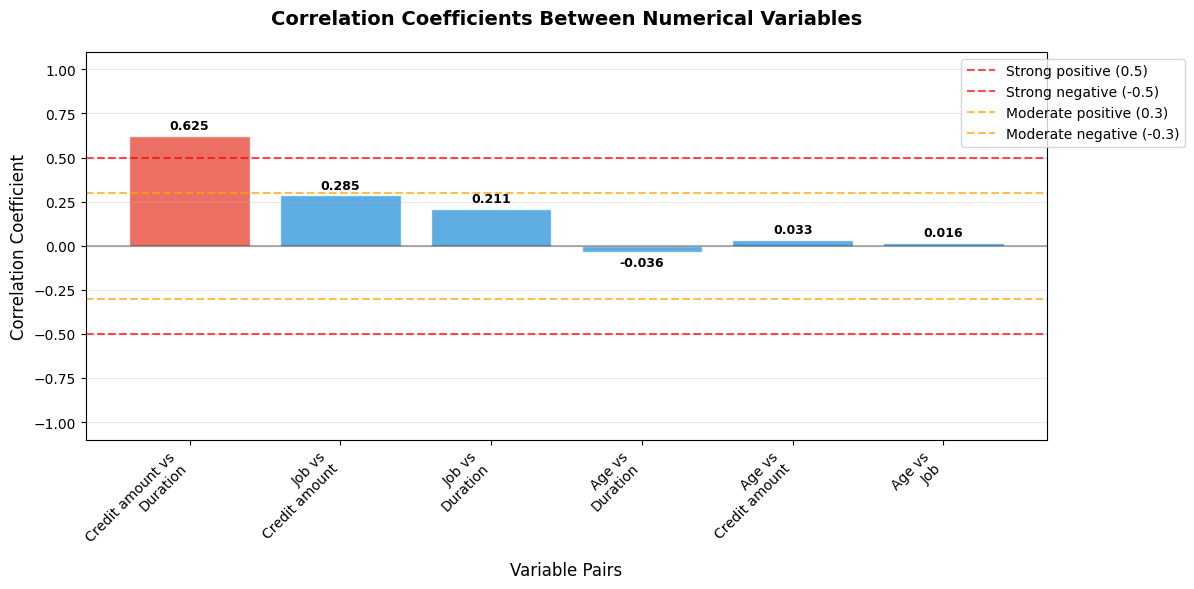

In [33]:
# Enhanced correlation analysis
print("CORRELATION ANALYSIS")
print("=" * 20)

# Calculate correlation matrix for numerical variables
correlation_matrix = df[numerical_cols].corr()

# Create enhanced correlation heatmap
plt.figure(figsize=(12, 10))

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Generate heatmap with improved styling
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r',  # Better color scheme
            center=0,
            square=True,
            fmt='.3f',
            cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
            annot_kws={"size": 12, "weight": "bold"},
            linewidths=0.5,
            linecolor='white')

plt.title('Correlation Matrix of Numerical Variables', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify and visualize strong correlations
print("\nCORRELATION ANALYSIS RESULTS")
print("-" * 30)
correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        correlation_pairs.append({
            'Variable 1': correlation_matrix.columns[i],
            'Variable 2': correlation_matrix.columns[j],
            'Correlation': corr_value,
            'Strength': abs(corr_value)
        })

# Sort by absolute correlation
correlation_pairs_df = pd.DataFrame(correlation_pairs).sort_values('Strength', ascending=False)

print("\nALL CORRELATIONS (sorted by strength):")
print(correlation_pairs_df.to_string(index=False, float_format='%.3f'))

# Strong correlations
strong_corr = correlation_pairs_df[correlation_pairs_df['Strength'] > 0.5]
if not strong_corr.empty:
    print(f"\nSTRONG CORRELATIONS (|r| > 0.5):")
    print("-" * 40)
    print(strong_corr[['Variable 1', 'Variable 2', 'Correlation']].to_string(index=False, float_format='%.3f'))
else:
    print("\nNo strong correlations found (|r| > 0.5)")

# Moderate correlations
moderate_corr = correlation_pairs_df[(correlation_pairs_df['Strength'] > 0.3) & 
                                    (correlation_pairs_df['Strength'] <= 0.5)]
if not moderate_corr.empty:
    print(f"\nMODERATE CORRELATIONS (0.3 < |r| ≤ 0.5):")
    print("-" * 45)
    print(moderate_corr[['Variable 1', 'Variable 2', 'Correlation']].to_string(index=False, float_format='%.3f'))

# Visualization of correlation strengths
if len(correlation_pairs_df) > 0:
    plt.figure(figsize=(12, 6))
    
    # Create labels for correlation pairs
    labels = [f"{row['Variable 1']} vs\n{row['Variable 2']}" 
              for _, row in correlation_pairs_df.iterrows()]
    
    # Create bar plot
    colors = ['#e74c3c' if abs(x) > 0.5 else '#f39c12' if abs(x) > 0.3 else '#3498db' 
              for x in correlation_pairs_df['Correlation']]
    
    bars = plt.bar(range(len(correlation_pairs_df)), 
                   correlation_pairs_df['Correlation'], 
                   color=colors, alpha=0.8,
                   edgecolor='white', linewidth=1)
    
    # Add value labels on bars
    for i, (bar, corr) in enumerate(zip(bars, correlation_pairs_df['Correlation'])):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 
                height + (0.02 if height >= 0 else -0.02),
                f'{corr:.3f}',
                ha='center', va='bottom' if height >= 0 else 'top',
                fontsize=9, fontweight='bold')
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Strong positive (0.5)')
    plt.axhline(y=-0.5, color='red', linestyle='--', alpha=0.7, label='Strong negative (-0.5)')
    plt.axhline(y=0.3, color='orange', linestyle='--', alpha=0.7, label='Moderate positive (0.3)')
    plt.axhline(y=-0.3, color='orange', linestyle='--', alpha=0.7, label='Moderate negative (-0.3)')
    
    plt.xlabel('Variable Pairs', fontsize=12)
    plt.ylabel('Correlation Coefficient', fontsize=12)
    plt.title('Correlation Coefficients Between Numerical Variables', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.ylim(-1.1, 1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

In [34]:
# DATA PREPARATION FOR MACHINE LEARNING
print("DATA PREPARATION FOR MACHINE LEARNING")
print("=" * 40)

# Separate features and target - use correct column name
X = df.drop('Risk', axis=1)  # Changed from 'risk' to 'Risk'
y = df['Risk']  # Changed from 'risk' to 'Risk'

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove index column from numerical features
if 'Unnamed: 0' in numerical_features:
    numerical_features.remove('Unnamed: 0')
    X = X.drop('Unnamed: 0', axis=1)  # Remove index column

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# Create feature engineering
from sklearn.preprocessing import LabelEncoder

# Create a copy for feature engineering
df_fe = df.copy()

# Target encoding
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"\nTarget classes: {target_encoder.classes_}")
print(f"Target distribution after encoding:")
print(f"Class 0 (good): {(y_encoded == 0).sum()}")
print(f"Class 1 (bad): {(y_encoded == 1).sum()}")

# Feature engineering: Create new features
print("\nFeature Engineering...")

# Age groups
df_fe['age_group'] = pd.cut(df_fe['Age'], 
                           bins=[0, 25, 35, 50, 100], 
                           labels=['young', 'adult', 'middle_aged', 'senior'])

# Credit amount groups
df_fe['amount_group'] = pd.cut(df_fe['Credit amount'], 
                              bins=[0, 2000, 5000, 10000, float('inf')], 
                              labels=['low', 'medium', 'high', 'very_high'])

# Duration groups
df_fe['duration_group'] = pd.cut(df_fe['Duration'], 
                                bins=[0, 12, 24, 36, float('inf')], 
                                labels=['short', 'medium', 'long', 'very_long'])

# New feature: Credit amount per month
df_fe['amount_per_month'] = df_fe['Credit amount'] / df_fe['Duration']

print("New features created successfully!")
print(f"Dataset shape after feature engineering: {df_fe.shape}")

DATA PREPARATION FOR MACHINE LEARNING
Categorical features: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
Numerical features: ['Age', 'Job', 'Credit amount', 'Duration']

Target classes: ['bad' 'good']
Target distribution after encoding:
Class 0 (good): 397
Class 1 (bad): 603

Feature Engineering...
New features created successfully!
Dataset shape after feature engineering: (1000, 14)


In [35]:
# ENCODE CATEGORICAL VARIABLES
print("ENCODING CATEGORICAL VARIABLES")
print("=" * 30)

# Select features for modeling
X = df_fe.drop('Risk', axis=1)  # Changed from 'risk' to 'Risk'
y = y_encoded

# Get categorical columns (including new ones)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove index column if present
if 'Unnamed: 0' in numerical_cols:
    numerical_cols.remove('Unnamed: 0')
    X = X.drop('Unnamed: 0', axis=1)

print(f"Categorical columns to encode: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# One-hot encoding for categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"\nShape after encoding: {X_encoded.shape}")
print("Encoding completed successfully!")

ENCODING CATEGORICAL VARIABLES
Categorical columns to encode: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'age_group', 'amount_group', 'duration_group']
Numerical columns: ['Age', 'Job', 'Credit amount', 'Duration', 'amount_per_month']

Shape after encoding: (1000, 29)
Encoding completed successfully!


In [36]:
# TRAIN-TEST SPLIT
print("TRAIN-TEST SPLIT")
print("=" * 16)

from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Check class distribution in train and test sets
train_sample = pd.DataFrame({'y': y_train})
test_sample = pd.DataFrame({'y': y_test})

train_bad_pct = (y_train == 1).mean() * 100
test_bad_pct = (y_test == 1).mean() * 100

print(f"\nClass distribution in training set:")
print(f"Good risk (0): {(y_train == 0).sum()} ({100-train_bad_pct:.1f}%)")
print(f"Bad risk (1): {(y_train == 1).sum()} ({train_bad_pct:.1f}%)")

print(f"\nClass distribution in test set:")
print(f"Good risk (0): {(y_test == 0).sum()} ({100-test_bad_pct:.1f}%)")
print(f"Bad risk (1): {(y_test == 1).sum()} ({test_bad_pct:.1f}%)")

print("Data split completed successfully!")

TRAIN-TEST SPLIT
Training set size: (800, 29)
Test set size: (200, 29)

Class distribution in training set:
Good risk (0): 318 (39.8%)
Bad risk (1): 482 (60.2%)

Class distribution in test set:
Good risk (0): 79 (39.5%)
Bad risk (1): 121 (60.5%)
Data split completed successfully!


In [37]:
# FEATURE SCALING
print("FEATURE SCALING")
print("=" * 15)

from sklearn.preprocessing import StandardScaler

# Identify columns to scale (numerical features)
columns_to_scale = [col for col in X_encoded.columns if col in numerical_cols or 'amount_per_month' in col]

print(f"Columns to scale: {columns_to_scale}")

# Initialize and fit scaler on training data
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only numerical columns
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

print("Feature scaling completed successfully!")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

FEATURE SCALING
Columns to scale: ['Age', 'Job', 'Credit amount', 'Duration', 'amount_per_month']
Feature scaling completed successfully!
Training set shape: (800, 29)
Test set shape: (200, 29)


BASELINE MODELS TRAINING

Training Logistic Regression...
Logistic Regression - Accuracy: 0.8350, AUC: 0.9166

Training Random Forest...
Random Forest - Accuracy: 0.8150, AUC: 0.8915

Training XGBoost...
Random Forest - Accuracy: 0.8150, AUC: 0.8915

Training XGBoost...
XGBoost - Accuracy: 0.8200, AUC: 0.9079

Baseline models training completed!

MODEL COMPARISON:
              Model  Accuracy      AUC
Logistic Regression     0.835 0.916623
      Random Forest     0.815 0.891464
            XGBoost     0.820 0.907940
XGBoost - Accuracy: 0.8200, AUC: 0.9079

Baseline models training completed!

MODEL COMPARISON:
              Model  Accuracy      AUC
Logistic Regression     0.835 0.916623
      Random Forest     0.815 0.891464
            XGBoost     0.820 0.907940


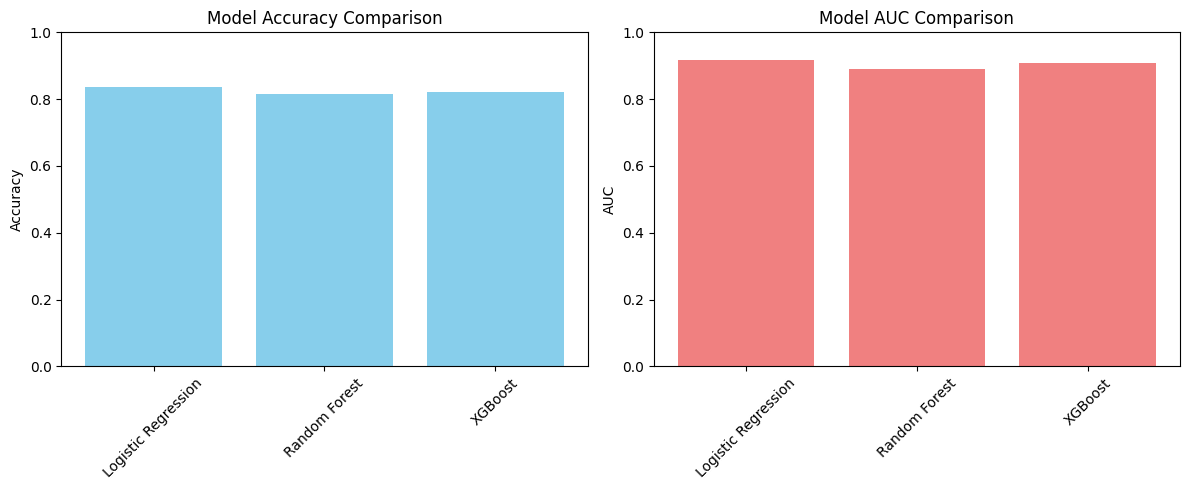

In [38]:
# BASELINE MODELS
print("BASELINE MODELS TRAINING")
print("=" * 25)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Train and evaluate models
models_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    models_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

print("\nBaseline models training completed!")

# Display results comparison
results_comparison = pd.DataFrame({
    'Model': list(models_results.keys()),
    'Accuracy': [results['accuracy'] for results in models_results.values()],
    'AUC': [results['auc'] for results in models_results.values()]
})

print("\nMODEL COMPARISON:")
print(results_comparison.to_string(index=False))

# Plot model comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
ax1.bar(results_comparison['Model'], results_comparison['Accuracy'], color='skyblue')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)

# AUC comparison
ax2.bar(results_comparison['Model'], results_comparison['AUC'], color='lightcoral')
ax2.set_title('Model AUC Comparison')
ax2.set_ylabel('AUC')
ax2.set_ylim(0, 1)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [39]:
# HYPERPARAMETER OPTIMIZATION
print("HYPERPARAMETER OPTIMIZATION")
print("=" * 27)

from sklearn.model_selection import GridSearchCV

# Define parameter grids
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Optimize Random Forest
print("Optimizing Random Forest...")
rf_base = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf_base, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_search_rf.fit(X_train_scaled, y_train)

print(f"Best RF parameters: {grid_search_rf.best_params_}")
print(f"Best RF cross-validation AUC: {grid_search_rf.best_score_:.4f}")

# Optimize XGBoost
print("\nOptimizing XGBoost...")
xgb_base = XGBClassifier(random_state=42, eval_metric='logloss')
grid_search_xgb = GridSearchCV(xgb_base, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
grid_search_xgb.fit(X_train_scaled, y_train)

print(f"Best XGB parameters: {grid_search_xgb.best_params_}")
print(f"Best XGB cross-validation AUC: {grid_search_xgb.best_score_:.4f}")

print("\nHyperparameter optimization completed!")

HYPERPARAMETER OPTIMIZATION
Optimizing Random Forest...
Best RF parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best RF cross-validation AUC: 0.9054

Optimizing XGBoost...
Best RF parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best RF cross-validation AUC: 0.9054

Optimizing XGBoost...
Best XGB parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best XGB cross-validation AUC: 0.9173

Hyperparameter optimization completed!
Best XGB parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best XGB cross-validation AUC: 0.9173

Hyperparameter optimization completed!


In [40]:
# EVALUATE OPTIMIZED MODELS
print("EVALUATING OPTIMIZED MODELS")
print("=" * 28)

# Get optimized models
rf_optimized = grid_search_rf.best_estimator_
xgb_optimized = grid_search_xgb.best_estimator_

# Evaluate optimized Random Forest
y_pred_rf_opt = rf_optimized.predict(X_test_scaled)
y_pred_proba_rf_opt = rf_optimized.predict_proba(X_test_scaled)[:, 1]
accuracy_rf_opt = accuracy_score(y_test, y_pred_rf_opt)
auc_rf_opt = roc_auc_score(y_test, y_pred_proba_rf_opt)

# Evaluate optimized XGBoost
y_pred_xgb_opt = xgb_optimized.predict(X_test_scaled)
y_pred_proba_xgb_opt = xgb_optimized.predict_proba(X_test_scaled)[:, 1]
accuracy_xgb_opt = accuracy_score(y_test, y_pred_xgb_opt)
auc_xgb_opt = roc_auc_score(y_test, y_pred_proba_xgb_opt)

print("OPTIMIZED MODELS PERFORMANCE:")
print("-" * 30)
print(f"Random Forest - Accuracy: {accuracy_rf_opt:.4f}, AUC: {auc_rf_opt:.4f}")
print(f"XGBoost - Accuracy: {accuracy_xgb_opt:.4f}, AUC: {auc_xgb_opt:.4f}")

# Compare with baseline models
print("\nCOMPARISON WITH BASELINE:")
print("-" * 25)
print(f"Random Forest improvement - Accuracy: {accuracy_rf_opt - models_results['Random Forest']['accuracy']:.4f}, AUC: {auc_rf_opt - models_results['Random Forest']['auc']:.4f}")
print(f"XGBoost improvement - Accuracy: {accuracy_xgb_opt - models_results['XGBoost']['accuracy']:.4f}, AUC: {auc_xgb_opt - models_results['XGBoost']['auc']:.4f}")

print("\nModel evaluation completed!")

EVALUATING OPTIMIZED MODELS
OPTIMIZED MODELS PERFORMANCE:
------------------------------
Random Forest - Accuracy: 0.8100, AUC: 0.8964
XGBoost - Accuracy: 0.8350, AUC: 0.9239

COMPARISON WITH BASELINE:
-------------------------
Random Forest improvement - Accuracy: -0.0050, AUC: 0.0050
XGBoost improvement - Accuracy: 0.0150, AUC: 0.0160

Model evaluation completed!


ROC CURVES ANALYSIS


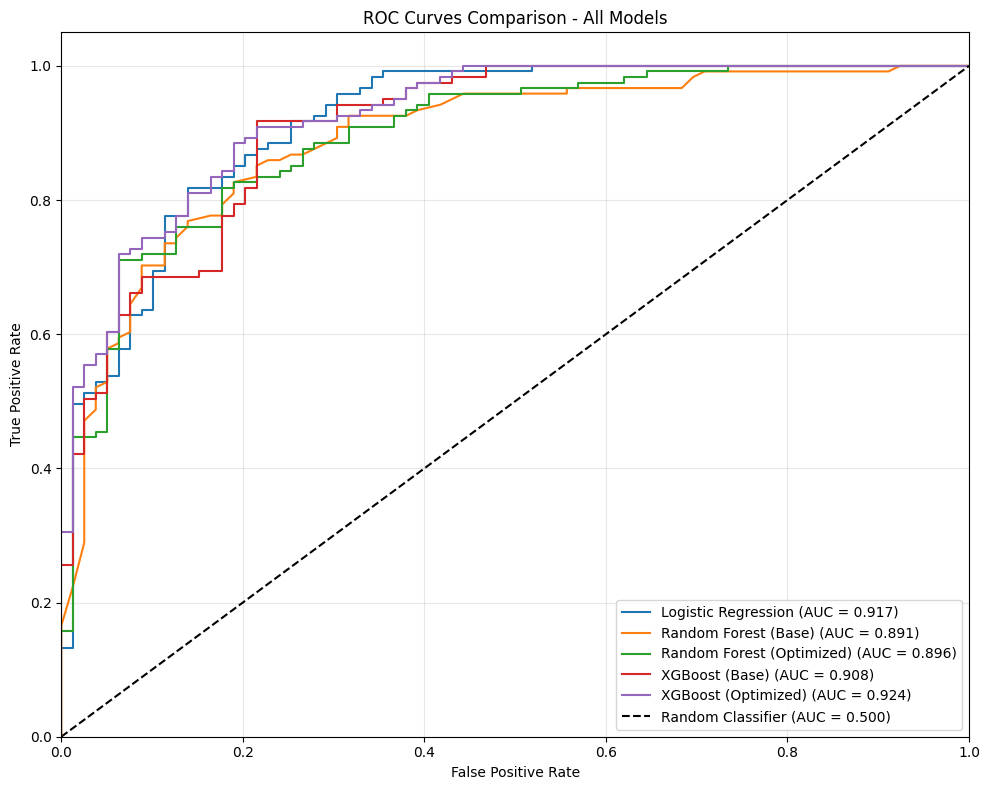

ROC curves analysis completed!


In [41]:
# ROC CURVES COMPARISON
print("ROC CURVES ANALYSIS")
print("=" * 19)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predictions from baseline models
lr_base = models_results['Logistic Regression']['model']
rf_base = models_results['Random Forest']['model']
xgb_base = models_results['XGBoost']['model']

# Calculate ROC curves for all models
models_data = [
    ('Logistic Regression', lr_base.predict_proba(X_test_scaled)[:, 1]),
    ('Random Forest (Base)', rf_base.predict_proba(X_test_scaled)[:, 1]),
    ('Random Forest (Optimized)', y_pred_proba_rf_opt),
    ('XGBoost (Base)', xgb_base.predict_proba(X_test_scaled)[:, 1]),
    ('XGBoost (Optimized)', y_pred_proba_xgb_opt)
]

# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, y_pred_proba in models_data:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison - All Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("ROC curves analysis completed!")

MODEL INTERPRETABILITY WITH SHAP
Best model: XGBoost (Optimized) (AUC: 0.9239)

Generating SHAP explanations...
Creating SHAP summary plot...


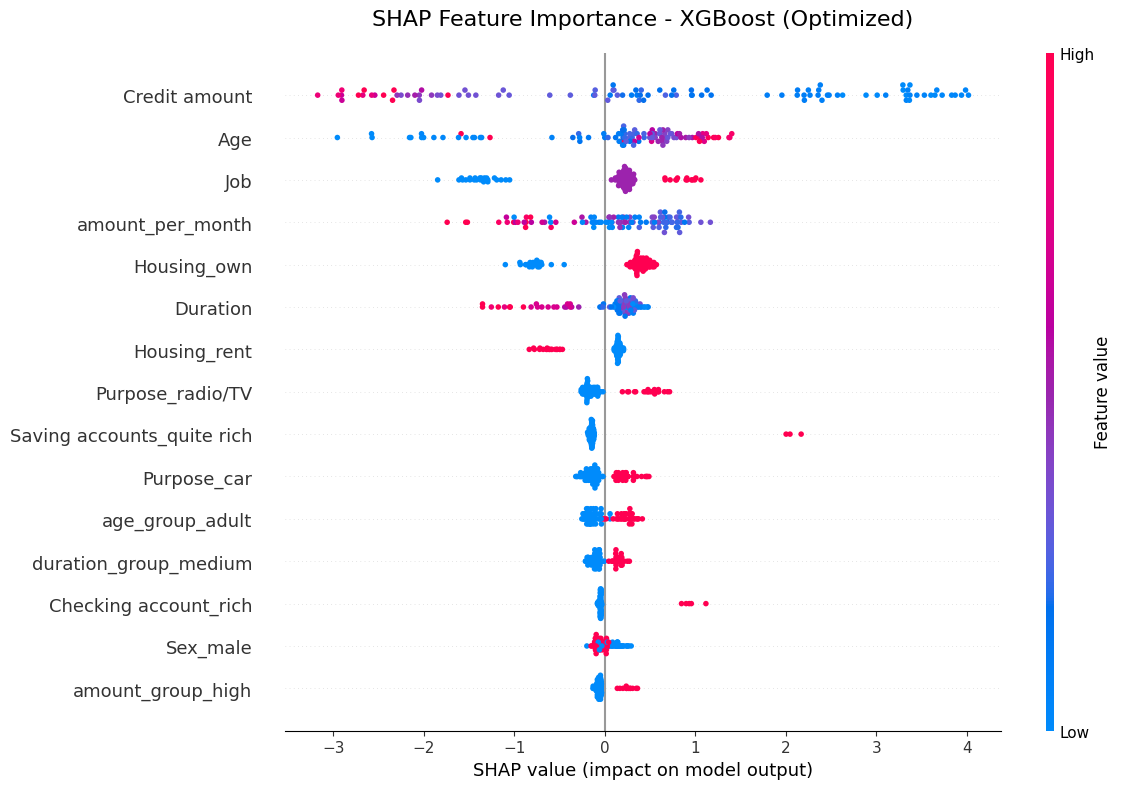

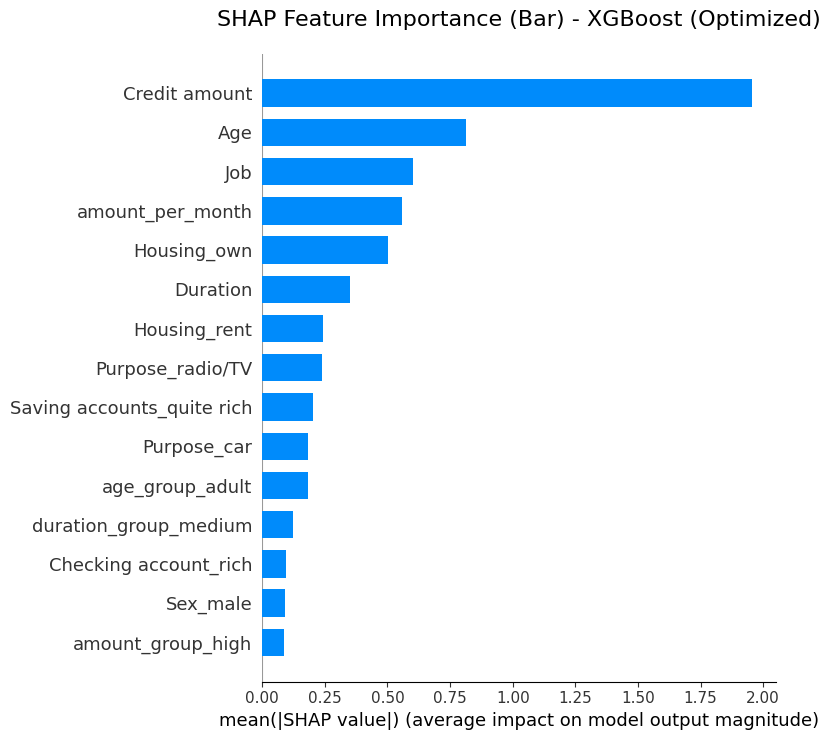

SHAP analysis completed!


In [42]:
# MODEL INTERPRETABILITY WITH SHAP
print("MODEL INTERPRETABILITY WITH SHAP")
print("=" * 33)

import shap

# Select best model based on AUC
best_models = {
    'Logistic Regression': models_results['Logistic Regression']['auc'],
    'Random Forest (Optimized)': auc_rf_opt,
    'XGBoost (Optimized)': auc_xgb_opt
}

best_model_name = max(best_models, key=best_models.get)
best_auc = best_models[best_model_name]

if 'Logistic Regression' in best_model_name:
    best_model = lr_base
elif 'Random Forest' in best_model_name:
    best_model = rf_optimized
else:
    best_model = xgb_optimized

print(f"Best model: {best_model_name} (AUC: {best_auc:.4f})")

# Create SHAP explainer
print("\nGenerating SHAP explanations...")

# Use a sample for SHAP analysis (for performance)
sample_size = min(100, len(X_test_scaled))

try:
    # Use TreeExplainer for tree-based models (faster and more accurate)
    if 'Random Forest' in best_model_name or 'XGBoost' in best_model_name:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_scaled.sample(sample_size, random_state=42))
        
        # For binary classification, XGBoost returns single array, RF returns array for each class
        if len(shap_values) == 2:  # Random Forest case
            shap_values_plot = shap_values[1]  # Use positive class
        else:  # XGBoost case
            shap_values_plot = shap_values
    else:
        # Use Explainer for linear models
        explainer = shap.Explainer(best_model, X_train_scaled.sample(50, random_state=42))
        shap_values = explainer(X_test_scaled.sample(sample_size, random_state=42))
        shap_values_plot = shap_values.values
    
    # Plot SHAP summary
    print("Creating SHAP summary plot...")
    
    # Create figure with better size
    plt.figure(figsize=(12, 8))
    
    if 'Random Forest' in best_model_name or 'XGBoost' in best_model_name:
        shap.summary_plot(shap_values_plot, 
                         X_test_scaled.sample(sample_size, random_state=42), 
                         max_display=15, 
                         show=False,
                         plot_size=(12, 8))
    else:
        shap.summary_plot(shap_values, 
                         max_display=15,
                         show=False,
                         plot_size=(12, 8))
    
    plt.title(f'SHAP Feature Importance - {best_model_name}', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Plot feature importance bar chart
    if 'Random Forest' in best_model_name or 'XGBoost' in best_model_name:
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values_plot, 
                         X_test_scaled.sample(sample_size, random_state=42),
                         plot_type="bar",
                         max_display=15,
                         show=False)
        plt.title(f'SHAP Feature Importance (Bar) - {best_model_name}', fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()
    
    print("SHAP analysis completed!")
    
except Exception as e:
    print(f"SHAP analysis failed: {str(e)}")
    print("Continuing without SHAP explanations...")
    
    # Fallback: Show feature importance from the model itself
    if hasattr(best_model, 'feature_importances_'):
        print("\nFallback: Model Feature Importances")
        feature_names = X_test_scaled.columns
        importances = best_model.feature_importances_
        
        # Create DataFrame for better visualization
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False).head(15)
        
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(feature_importance_df)), feature_importance_df['importance'])
        plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Feature Importance - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Most Important Features:")
        print(feature_importance_df.head(10).to_string(index=False))

In [43]:
# FINAL RESULTS AND MODEL SAVING
print("FINAL RESULTS AND MODEL SAVING")
print("=" * 31)

# Select final model (best performing)
final_model = best_model
print(f"Final selected model: {best_model_name}")
print(f"Final model AUC: {best_auc:.4f}")

# Create results summary
results_summary = {
    'Best Model': best_model_name,
    'Test Accuracy': accuracy_score(y_test, final_model.predict(X_test_scaled)),
    'Test AUC': best_auc,
    'Training Samples': len(X_train_scaled),
    'Test Samples': len(X_test_scaled),
    'Features': X_test_scaled.shape[1]
}

print("\nFINAL MODEL PERFORMANCE:")
print("-" * 25)
for key, value in results_summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Save model and preprocessing objects
import joblib
import os

# Create save directory
save_dir = '../models'
os.makedirs(save_dir, exist_ok=True)

# Save model
model_path = os.path.join(save_dir, 'best_model.pkl')  # Consistent name with prediction function
joblib.dump(final_model, model_path)

# Save scaler  
scaler_path = os.path.join(save_dir, 'scaler.pkl')  # Consistent name with prediction function
joblib.dump(scaler, scaler_path)

# Save target encoder
target_encoder_path = os.path.join(save_dir, 'target_encoder.pkl')
joblib.dump(target_encoder, target_encoder_path)

# Save feature names
feature_names_path = os.path.join(save_dir, 'feature_names.txt')
with open(feature_names_path, 'w') as f:
    for feature in X_train_scaled.columns:
        f.write(f"{feature}\n")

# Save results summary
results_path = os.path.join(save_dir, 'model_results.txt')
with open(results_path, 'w') as f:
    f.write("German Credit Risk Model - Final Results\n")
    f.write("=" * 40 + "\n\n")
    for key, value in results_summary.items():
        f.write(f"{key}: {value}\n")

print(f"\nModel and artifacts saved to: {save_dir}")
print("Analysis completed successfully!")

# Display final message
print("\n" + "="*50)
print("GERMAN CREDIT RISK ANALYSIS COMPLETED")
print("="*50)
print(f"Best Model: {best_model_name}")
print(f"Test AUC: {best_auc:.4f}")
print(f"All files saved to: {save_dir}")
print("="*50)

FINAL RESULTS AND MODEL SAVING
Final selected model: XGBoost (Optimized)
Final model AUC: 0.9239

FINAL MODEL PERFORMANCE:
-------------------------
Best Model: XGBoost (Optimized)
Test Accuracy: 0.8350
Test AUC: 0.9239
Training Samples: 800
Test Samples: 200
Features: 29

Model and artifacts saved to: ../models
Analysis completed successfully!

GERMAN CREDIT RISK ANALYSIS COMPLETED
Best Model: XGBoost (Optimized)
Test AUC: 0.9239
All files saved to: ../models


# Practical Model Demonstration

Now that our optimized XGBoost model is ready, let's test it with some simulated client cases to see how it predicts credit risk.

In [44]:
# Function to predict credit risk for a new client
def predict_credit_risk(age, sex, job, housing, saving_accounts, checking_account, 
                       credit_amount, duration, purpose):
    """
    Predicts credit risk for a new client
    
    Parameters:
    - age: client age
    - sex: gender ('male' or 'female')
    - job: employment (0=unskilled, 1=skilled, 2=highly_skilled, 3=management)
    - housing: housing ('own', 'rent', 'free')
    - saving_accounts: savings accounts ('little', 'moderate', 'rich', 'quite rich', or None)
    - checking_account: checking account ('little', 'moderate', 'rich', or None)
    - credit_amount: credit amount
    - duration: duration in months
    - purpose: credit purpose (e.g., 'car', 'education', 'furniture/equipment', etc.)
    
    Returns:
    - risk probability and prediction
    """
    
    # Use the model and scaler already defined in the notebook
    try:
        # Check that model and scaler exist
        model = final_model
        model_scaler = scaler
        print("Using model and scaler from notebook")
    except NameError:
        # Try to load from saved files
        try:
            import joblib
            model = joblib.load('../models/best_model.pkl')
            model_scaler = joblib.load('../models/scaler.pkl')
            print("Model and scaler loaded from saved files")
        except FileNotFoundError:
            print("Model not found. Please first run the previous notebook cells.")
            return None, None
    
    # Create a DataFrame with client data
    client_data = pd.DataFrame({
        'Age': [age],
        'Sex': [sex],
        'Job': [job],
        'Housing': [housing],
        'Saving accounts': [saving_accounts],
        'Checking account': [checking_account],
        'Credit amount': [credit_amount],
        'Duration': [duration],
        'Purpose': [purpose]
    })
    
    # COMPLETE FEATURE ENGINEERING - reproduce exactly as in notebook
    client_data['amount_per_month'] = client_data['Credit amount'] / client_data['Duration']
    
    # Create age groups EXACTLY as in notebook
    client_data['age_group'] = pd.cut(client_data['Age'], 
                                    bins=[0, 25, 35, 50, 100], 
                                    labels=['young', 'adult', 'middle_aged', 'senior'])
    
    # Create amount groups
    client_data['amount_group'] = pd.cut(client_data['Credit amount'], 
                                       bins=[0, 2000, 5000, 10000, float('inf')], 
                                       labels=['low', 'medium', 'high', 'very_high'])
    
    # Create duration groups EXACTLY as in notebook
    client_data['duration_group'] = pd.cut(client_data['Duration'], 
                                         bins=[0, 12, 24, 36, float('inf')], 
                                         labels=['short', 'medium', 'long', 'very_long'])
    
    # Encode categorical variables EXACTLY as in notebook
    categorical_features = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'age_group', 'amount_group', 'duration_group']
    client_encoded = pd.get_dummies(client_data, columns=categorical_features, drop_first=True)
    
    # Remove Risk column if it exists
    if 'Risk' in client_encoded.columns:
        client_encoded = client_encoded.drop('Risk', axis=1)
    
    # Expected columns by the model (29 final columns)
    expected_columns = ['Age', 'Job', 'Credit amount', 'Duration', 'amount_per_month', 
                       'Sex_male', 'Housing_own', 'Housing_rent', 
                       'Saving accounts_moderate', 'Saving accounts_quite rich', 'Saving accounts_rich', 
                       'Checking account_moderate', 'Checking account_rich', 
                       'Purpose_car', 'Purpose_domestic appliances', 'Purpose_education', 
                       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs', 
                       'Purpose_vacation/others', 'age_group_adult', 'age_group_middle_aged', 'age_group_senior', 
                       'amount_group_medium', 'amount_group_high', 'amount_group_very_high', 
                       'duration_group_medium', 'duration_group_long', 'duration_group_very_long']
    
    # Ensure all expected columns are present
    for col in expected_columns:
        if col not in client_encoded.columns:
            client_encoded[col] = 0
    
    # Reorder columns in the same order
    client_encoded = client_encoded.reindex(columns=expected_columns, fill_value=0)
    
    # Normalize ONLY numerical columns (as in notebook)
    numerical_cols = ['Age', 'Job', 'Credit amount', 'Duration', 'amount_per_month']
    client_for_scaling = client_encoded.copy()
    client_for_scaling[numerical_cols] = model_scaler.transform(client_encoded[numerical_cols])
    
    # Make prediction
    prediction = model.predict(client_for_scaling)[0]
    probability = model.predict_proba(client_for_scaling)[0]
    
    # Interpret result
    risk_level = "GOOD RISK" if prediction == 0 else "BAD RISK"
    confidence = max(probability) * 100
    
    print(f"=== CLIENT ANALYSIS ===")
    print(f"Prediction: {risk_level}")
    print(f"Confidence: {confidence:.1f}%")
    print(f"Good risk probability: {probability[0]:.3f}")
    print(f"Bad risk probability: {probability[1]:.3f}")
    print(f"Amount per month: {client_data['amount_per_month'].iloc[0]:.2f}")
    print(f"Age group: {client_data['age_group'].iloc[0]}")
    print(f"Amount group: {client_data['amount_group'].iloc[0]}")
    print(f"Duration group: {client_data['duration_group'].iloc[0]}")
    
    return prediction, probability

print("Prediction function created successfully!")
print()
print("INSTRUCTIONS FOR USING THE FUNCTION:")
print("   1. First run ALL previous cells in the notebook")
print("   2. This will train the model and create necessary variables")
print("   3. Then you can use the prediction examples below")
print("   4. The model will also be saved in ../models/ for future use")

Prediction function created successfully!

INSTRUCTIONS FOR USING THE FUNCTION:
   1. First run ALL previous cells in the notebook
   2. This will train the model and create necessary variables
   3. Then you can use the prediction examples below
   4. The model will also be saved in ../models/ for future use


In [45]:
# EXAMPLE 1: Client with favorable profile
print("EXAMPLE 1: CLIENT WITH FAVORABLE PROFILE")
print("-" * 50)

prediction1, prob1 = predict_credit_risk(
    age=35,
    sex='male',
    job=2,  # highly skilled
    housing='own',
    saving_accounts='rich',
    checking_account='rich',
    credit_amount=3000,
    duration=12,
    purpose='car'
)
print()

EXAMPLE 1: CLIENT WITH FAVORABLE PROFILE
--------------------------------------------------
Using model and scaler from notebook
=== CLIENT ANALYSIS ===
Prediction: BAD RISK
Confidence: 65.5%
Good risk probability: 0.345
Bad risk probability: 0.655
Amount per month: 250.00
Age group: adult
Amount group: medium
Duration group: short



In [46]:
# EXAMPLE 2: Client with riskier profile
print("EXAMPLE 2: CLIENT WITH RISKIER PROFILE")
print("-" * 50)

prediction2, prob2 = predict_credit_risk(
    age=22,
    sex='female',
    job=0,  # unskilled
    housing='rent',
    saving_accounts=None,  # no savings account
    checking_account='little',
    credit_amount=8000,
    duration=36,
    purpose='furniture/equipment'
)
print()

EXAMPLE 2: CLIENT WITH RISKIER PROFILE
--------------------------------------------------
Using model and scaler from notebook
=== CLIENT ANALYSIS ===
Prediction: GOOD RISK
Confidence: 100.0%
Good risk probability: 1.000
Bad risk probability: 0.000
Amount per month: 222.22
Age group: young
Amount group: high
Duration group: long



In [47]:
# EXAMPLE 3: Client with intermediate profile
print("EXAMPLE 3: CLIENT WITH INTERMEDIATE PROFILE")
print("-" * 50)

prediction3, prob3 = predict_credit_risk(
    age=45,
    sex='male',
    job=1,  # skilled
    housing='own',
    saving_accounts='moderate',
    checking_account=None,  # no checking account
    credit_amount=5000,
    duration=24,
    purpose='education'
)
print()

EXAMPLE 3: CLIENT WITH INTERMEDIATE PROFILE
--------------------------------------------------
Using model and scaler from notebook
=== CLIENT ANALYSIS ===
Prediction: GOOD RISK
Confidence: 95.7%
Good risk probability: 0.957
Bad risk probability: 0.043
Amount per month: 208.33
Age group: middle_aged
Amount group: medium
Duration group: medium



In [48]:
# INTERACTIVE SECTION: Test your own client
print("TEST YOUR OWN CLIENT")
print("-" * 50)
print("Modify the values below to test different profiles:")
print()

# Customizable example - modify these values
my_client = {
    'age': 30,
    'sex': 'female',  # 'male' or 'female'
    'job': 1,  # 0=unskilled, 1=skilled, 2=highly_skilled, 3=management
    'housing': 'rent',  # 'own', 'rent', 'free'
    'saving_accounts': 'little',  # 'little', 'moderate', 'rich', 'quite_rich', or None
    'checking_account': 'moderate',  # 'little', 'moderate', 'rich', or None
    'credit_amount': 4500,
    'duration': 18,
    'purpose': 'car'  # 'car', 'education', 'business', etc.
}

print("Client profile being tested:")
for key, value in my_client.items():
    print(f"  {key}: {value}")
print()

# Prediction for your client
my_prediction, my_prob = predict_credit_risk(**my_client)

print()
print("Tip: Modify the values in the 'my_client' section above")
print("   and rerun this cell to test different profiles!")

TEST YOUR OWN CLIENT
--------------------------------------------------
Modify the values below to test different profiles:

Client profile being tested:
  age: 30
  sex: female
  job: 1
  housing: rent
  saving_accounts: little
  checking_account: moderate
  credit_amount: 4500
  duration: 18
  purpose: car

Using model and scaler from notebook
=== CLIENT ANALYSIS ===
Prediction: GOOD RISK
Confidence: 99.4%
Good risk probability: 0.994
Bad risk probability: 0.006
Amount per month: 250.00
Age group: adult
Amount group: medium
Duration group: medium

Tip: Modify the values in the 'my_client' section above
   and rerun this cell to test different profiles!
